In [1]:
# Tahap 1: Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from tqdm import tqdm

train_raw = pd.read_csv("train.csv")
print("Total interactions (raw):", len(train_raw))
train_raw.head()

Total interactions (raw): 269764


,user_id,item_id
0,8,0002005018
1,8,074322678X
2,8,0887841740
3,8,1552041778
4,8,1567407781


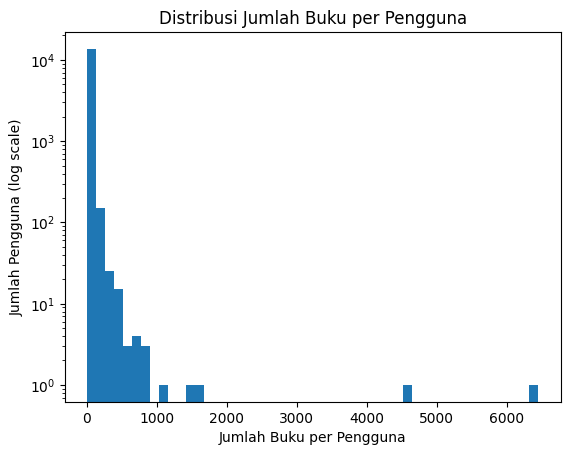

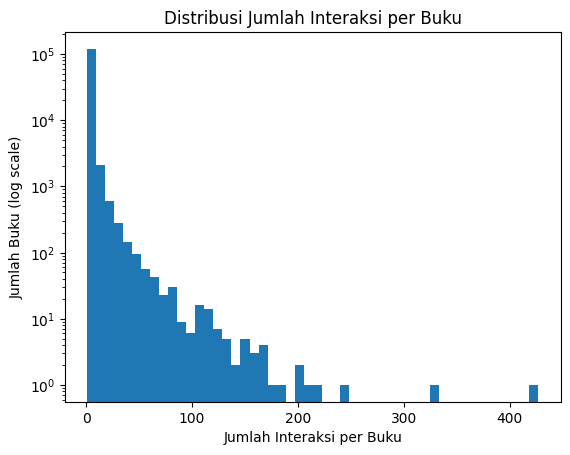

In [2]:
# Tahap 2: EDA (Distribusi Data)

## Distribusi Jumlah Buku per Pengguna
user_interaction_dist = train_raw["user_id"].value_counts()

plt.figure()
plt.hist(user_interaction_dist, bins=50, log=True)
plt.xlabel("Jumlah Buku per Pengguna")
plt.ylabel("Jumlah Pengguna (log scale)")
plt.title("Distribusi Jumlah Buku per Pengguna")
plt.show()

## Distribusi Jumalh Interaksi per Buku
item_interaction_dist = train_raw["item_id"].value_counts()

plt.figure()
plt.hist(item_interaction_dist, bins=50, log=True)
plt.xlabel("Jumlah Interaksi per Buku")
plt.ylabel("Jumlah Buku (log scale)")
plt.title("Distribusi Jumlah Interaksi per Buku")
plt.show()

In [3]:
# Tahap 3: Filtering Data
MIN_USER_INTERACTIONS = 5
MIN_ITEM_INTERACTIONS = 5

# Filter user
user_counts = train_raw["user_id"].value_counts()
valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
train = train_raw[train_raw["user_id"].isin(valid_users)]

# Filter item
item_counts = train["item_id"].value_counts()
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index
train = train[train["item_id"].isin(valid_items)]

train = train.reset_index(drop=True)

print("Setelah filtering awal:")
print("Interactions:", len(train))
print("Users:", train["user_id"].nunique())
print("Items:", train["item_id"].nunique())

Setelah filtering awal:
Interactions: 110546
Users: 10678
Items: 8833


In [4]:
# Tahap 4: Filter ulang user agar minimal punya 2 interaksi (aman untuk split)
user_counts = train["user_id"].value_counts()
valid_users = user_counts[user_counts >= 2].index
train = train[train["user_id"].isin(valid_users)].reset_index(drop=True)

print("Setelah filter ulang user:")
print("Users:", train["user_id"].nunique())
print("Interactions:", len(train))

Setelah filter ulang user:
Users: 9619
Interactions: 109487


In [5]:
# Tahap 5: Split data jadi train-test per user
train_list, test_list = [], []

for uid, group in train.groupby("user_id"):
    tr, te = train_test_split(group, test_size=0.2, random_state=42)
    train_list.append(tr)
    test_list.append(te)

train_split = pd.concat(train_list)
test_split = pd.concat(test_list)

print("Train size:", len(train_split))
print("Test size:", len(test_split))

Train size: 83851
Test size: 25636


In [6]:
# Tahap 6: Encode user & item ke index numerik
user_to_index = {u: i for i, u in enumerate(train_split["user_id"].unique())}
item_to_index = {i: j for j, i in enumerate(train_split["item_id"].unique())}

index_to_user = {i: u for u, i in user_to_index.items()}
index_to_item = {j: i for i, j in item_to_index.items()}

user_index = train_split["user_id"].map(user_to_index)
item_index = train_split["item_id"].map(item_to_index)

In [7]:
# Tahap 7: Buat weighted user-item matrix (TF-IDF style)
item_freq = train_split["item_id"].value_counts()
item_weight = 1.0 / np.log1p(item_freq)

train_split["weight"] = train_split["item_id"].map(item_weight)

user_item_csr = csr_matrix(
    (train_split["weight"].astype(np.float32), (user_index, item_index)),
    shape=(len(user_to_index), len(item_to_index))
)

print("CSR shape:", user_item_csr.shape)

CSR shape: (9619, 8828)


In [8]:
# Tahap 8: Fit NearestNeighbors untuk Item Similarity
top_k = 30  # lebih kecil = lebih fokus
item_matrix = user_item_csr.T  # item × user

model = NearestNeighbors(
    metric="cosine",
    algorithm="brute",
    n_neighbors=top_k + 1,
    n_jobs=-1
)
model.fit(item_matrix)

distances, neighbors = model.kneighbors(item_matrix)
similarities = 1.0 - distances

neighbors = neighbors[:, 1:]
similarities = similarities[:, 1:]

print("Neighbors shape:", neighbors.shape)

Neighbors shape: (8828, 30)


In [9]:
# Tahap 9: Precompute Global Top-10 Item (fallback)
global_top10 = train_split['item_id'].value_counts().head(10).index.tolist()


# Tahap 10: Fungsi Rekomendasi per User
def recommend_for_user_id(user_id, top_n=10):
    # Jika user tidak ada (cold-start)
    if user_id not in user_to_index:
        return global_top10

    u_idx = user_to_index[user_id]
    interacted = user_item_csr[u_idx].indices

    if len(interacted) == 0:
        return global_top10

    scores = {}

    for item in interacted:
        for nbr, sim in zip(neighbors[item], similarities[item]):
            if nbr in interacted:
                continue
            scores[nbr] = scores.get(nbr, 0.0) + sim / len(interacted)

    if not scores:
        return global_top10

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [index_to_item[i] for i, _ in ranked[:top_n]]


# Tahap 11: Hasil Rekomendasi untuk Semua User
results = []

for uid in tqdm(user_to_index.keys(), desc="Membuat rekomendasi"):
    recs = recommend_for_user_id(uid, top_n=10)
    results.append({
        "user_id": uid,
        "item_id": " ".join(map(str, recs))
    })

recommend_df = pd.DataFrame(results)
recommend_df.to_csv("ibcf_top10_submission.csv", index=False)

print("File rekomendasi berhasil dibuat")


Membuat rekomendasi: 100%|██████████| 9619/9619 [00:21<00:00, 451.01it/s]


File rekomendasi berhasil dibuat


In [10]:
# Tampilan Top-10 Rekomendasi
sample_users = recommend_df.sample(10, random_state=42)

for _, row in sample_users.iterrows():
    print(f"User {row['user_id']} → {row['item_id'].split()}")

User 174830 → ['0553280341', '0553279556', '0553284789', '0449221512', '0449219461', '0060974486', '0449221504', '0312186886', '0515090506', '0449219364']
User 256844 → ['067084943X', '0064407314', '0380795116', '0425150429', '0345402308', '0385311923', '0553571842', '0380761319', '0316171638', '0451198646']
User 133258 → ['0312975228', '0525947655', '0425184056', '0449000613', '0800718372', '0764226312', '0520204956', '0451188470', '0440223571', '0373031467']
User 276017 → ['0515138096', '0373441754', '0515136530', '0345463935', '0440236908', '0515135968', '0373790775', '0385338252', '051513628X', '0451411129']
User 240033 → ['0451206096', '0380800802', '0375400516', '067084943X', '0446603856', '0394800303', '0836218817', '0061032077', '0064407314', '0451150325']
User 189151 → ['0446400165', '0064407314', '067084943X', '0515103454', '0061092886', '0399148612', '0451405498', '0380700247', '0307301451', '0452283485']
User 51992 → ['067084943X', '0064407314', '0060185074', '0060391839', 

In [11]:
# Tahap 12: Evaluasi MAP@10
def average_precision_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    predicted = predicted[:k]
    score, hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(actual), k)

test_truth = (
    test_split.groupby("user_id")["item_id"]
    .apply(set)
    .to_dict()
)

# Filter user test ≥ 2
test_truth = {u: v for u, v in test_truth.items() if len(v) >= 2}

map_scores = []
for _, row in recommend_df.iterrows():
    uid = row["user_id"]
    preds = row["item_id"].split()
    actual = test_truth.get(uid, set())
    map_scores.append(average_precision_at_k(actual, preds, k=10))

map10 = np.mean(map_scores)
print(f"MAP@10: {map10:.6f}")

MAP@10: 0.013683
